### Politeness prediction with ConvoKit

This notebook demonstrates how to train a simple classifier to predict the politeness level of a request by considering the politeness strategies used, as seen in the paper [A computational approach to politeness with application to social factors](https://www.cs.cornell.edu/~cristian/Politeness.html), using ConvoKit. Note that this notebook is *not* intended to reproduce the paper results: legacy code for reproducibility is available at this [repository](https://github.com/sudhof/politeness). 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [ ]:
# #import sys
# #sys.path.insert(0, "Cornell-Conversational-Analysis-Toolkit/")

import convokit
print(convokit.__file__)

In [3]:
from convokit import Corpus, User, Utterance

In [4]:
from pandas import DataFrame
from typing import List, Dict, Set

#### 1: Loading (and converting) annotated dataset

We will be using the wikipedia annotations from the [Stanford Politeness Corpus](https://www.cs.cornell.edu/~cristian/Politeness.html). 

Code below demonstrates how to convert the original CSV file into the corpus format expected by ConvoKit, but this resultant corpus can also be directly downloaded using the helper function `download("wiki-politeness-annotated")`. 

In [ ]:
# you may need to modify the filepath depending on where your downloaded version is stored 
df = pd.read_csv("Stanford_politeness_corpus/wikipedia.annotated.csv")

To see how the data looks:

In [ ]:
df.head(2)

Firstly, we need to convert it to the format ConvoKit expects. Here is a simple helper function that does the job. 

In [ ]:
def convert_df_to_corpus(df: DataFrame, id_col: str, text_col: str, meta_cols: List[str]) -> Corpus:
    
    """ Helper function to convert data to Corpus format
     
    Arguments:
        df {DataFrame} -- Actual data, in a pandas Dataframe
        id_col {str} -- name of the column that corresponds to utterances ids 
        text_col {str} -- name of the column that stores texts of the utterances  
        meta_cols {List[str]} -- set of columns that stores relevant metadata 
    
    Returns:
        Corpus -- the converted corpus
    """
    
    # in this particular case, user, reply_to, and timestamp information are all not applicable 
    # and we will simply either create a placeholder entry, or leave it as None 
        
    user = User("wiki_user")
    time = "NOT_RECORDED"

    utterance_list = []    
    for index, row in tqdm(df.iterrows()):
        
        # extracting meta data
        metadata = {}
        for meta_col in meta_cols:
            metadata[meta_col] = row[meta_col]
        
        utterance_list.append(Utterance(str(row[id_col]), user, row[id_col], None, time, \
                                        row[text_col], meta=metadata))
    
    return Corpus(utterances = utterance_list)

For meta data, we will include the normalized score, its corresponding binary label (based on a 75% vs. 25% percentile cutoff -- technically there are three classes, but we will only look at the two ends, thus "binary"), as well as all original annotations with turker information. 

- Adding detailed annotations information to dataframe 

In [ ]:
# for simplicity, we will condense the turker information together
df["Annotations"] = [dict(zip([df.iloc[i]["TurkId{}".format(j)] for j in range(1,6)], \
                             [df.iloc[i]["Score{}".format(j)] for j in range(1,6)])) for i in tqdm(range(len(df)))]

- obtaining polite vs. impolite label (note that we are only interested in labels that are either +1 or -1)

In [ ]:
# computing the binary label based on Normalized score
top = np.percentile(df['Normalized Score'], 75)
bottom = np.percentile(df["Normalized Score"], 25)
df['Binary'] = [int(score >= top) - int(score <= bottom) for score in df['Normalized Score']]

- converting dataframe to corpus

In [ ]:
wiki_corpus = convert_df_to_corpus(df, "Id", "Request", ["Normalized Score", "Binary", "Annotations"])

In [6]:
# if you were to download the data directly, here is how: 
from convokit import download
wiki_corpus = Corpus(download("wiki-politeness-annotated"))

#### 2: Annotate the corpus with politeness strategies

To get politeness strategies for each utterance, we will first obtain dependency parses for the utterances, and then check for strategy use. 

- adding dependency parses

In [7]:
from convokit import TextParser
parser = TextParser(verbosity=1000)

In [8]:
wiki_corpus = parser.transform(wiki_corpus)

1000/4353 utterances processed
2000/4353 utterances processed
3000/4353 utterances processed
4000/4353 utterances processed
4353/4353 utterances processed


- adding strategy information

In [9]:
from convokit import PolitenessStrategies
ps = PolitenessStrategies()

In [10]:
wiki_corpus = ps.transform(wiki_corpus, markers=True)

Below is an example of how a processed utterance now look. Dependency parses are stored in `parsed`, and politeness strategies are in `politeness_strategies`. The positive occurances of each politeness strategies are stored in `politeness_markers`.

In [11]:
wiki_corpus.get_utterance('434044')

Utterance({'obj_type': 'utterance', '_owner': <convokit.model.corpus.Corpus object at 0x10ecff940>, 'meta': {'Normalized Score': 0.6945444785369653, 'Binary': 1, 'Annotations': {'A233ONYNWKDIYF': 17, 'A1QV3X9YMQQ3OQ': 22, 'A3OW54MEVDKXJL': 17, 'A1JK9DYKWYZZEK': 17, 'AZ1RJVNOZFIWV': 18}, 'parsed': [{'rt': 7, 'toks': [{'tok': 'hey', 'tag': 'NNP', 'dep': 'intj', 'up': 7, 'dn': [1]}, {'tok': 'mbk', 'tag': 'NNP', 'dep': 'intj', 'up': 0, 'dn': []}, {'tok': ';', 'tag': ':', 'dep': 'punct', 'up': 7, 'dn': []}, {'tok': 'well', 'tag': 'UH', 'dep': 'intj', 'up': 7, 'dn': []}, {'tok': ',', 'tag': ',', 'dep': 'punct', 'up': 7, 'dn': []}, {'tok': 'i', 'tag': 'PRP', 'dep': 'nsubj', 'up': 7, 'dn': []}, {'tok': 've', 'tag': 'VB', 'dep': 'aux', 'up': 7, 'dn': []}, {'tok': 'got', 'tag': 'VBN', 'dep': 'ROOT', 'dn': [0, 2, 3, 4, 5, 6, 9]}, {'tok': 'to', 'tag': 'TO', 'dep': 'aux', 'up': 9, 'dn': []}, {'tok': 'be', 'tag': 'VB', 'dep': 'xcomp', 'up': 7, 'dn': [8, 10]}, {'tok': 'honest', 'tag': 'JJ', 'dep': 'a

Here is a clearer view of the politeness_markers:

In [12]:
utt = wiki_corpus.get_utterance('434044')
print("RAW TEXT: " + utt.text + "\n")
for ((k,v),(k1,v2)) in zip(utt.meta["politeness_strategies"].items(),utt.meta["politeness_markers"].items()):
    if v != 0:
        print(k[21:len(k)-2] + " results:")
        print("Markers: " + str(v2) + "\n")

RAW TEXT: Hey MBK; well, I've got to be honest I wasn't expecting the events of last night - personally I thought the discussion was going reasonably well (not fabulously, but we were getting somewhere) and, whilst I agree that Mlm's actions weren't exactly advised, I must admit it does seem to be a relatively minor thing to retire over - was there something else going on here that made it the straw that broke his back? Anyhow, I agree with you that he'll be greatly missed - I sent him a message on NSF but I doubt if I'll get any reply - what are your thoughts on the matter?

HASHEDGE results:
Markers: [[('thought', 2, 2)], [('relatively', 3, 10)], [('doubt', 6, 2)]]

Hedges results:
Markers: [[('i', 2, 1), ('thought', 2, 2)], [('i', 6, 1), ('doubt', 6, 2)]]

1st_person_pl. results:
Markers: [[('we', 2, 14)]]

1st_person results:
Markers: [[('i', 0, 5)], [('i', 2, 1)], [('i', 2, 22)], [('i', 3, 1)], [('i', 4, 2)], [('i', 6, 1)], [('i', 6, 4)]]

1st_person_start results:
Markers: [[('i'

You may want to save the corpus by doing `wiki_corpus.dump("wiki-politeness-annotated")` for further exploration. Note that if you do not specify a base path, data will be saved to `.convokit/saved-corpora` in your home directory by default. 

To get a glimpse of the overall use of politeness strategies in this corpus: 

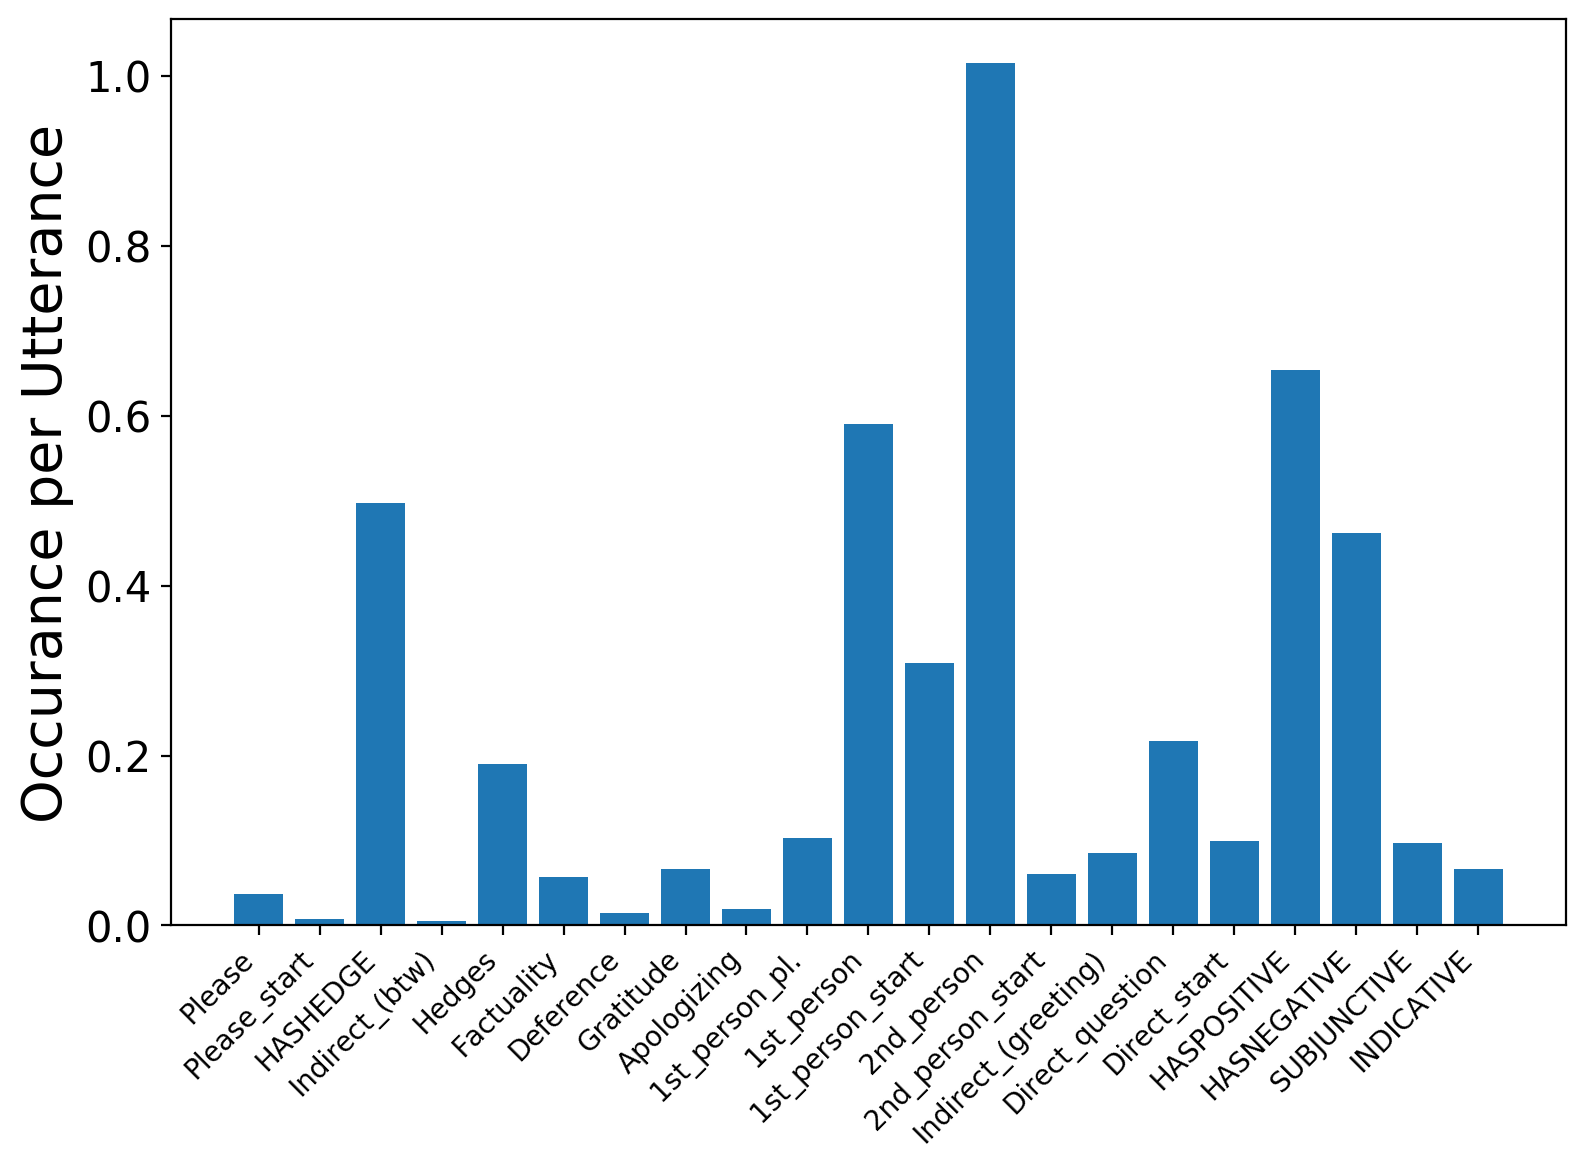

In [13]:
data = ps.summarize(wiki_corpus, plot=True)

You can also look at particular sections of the dataset, such as only the utterances that use positive words:

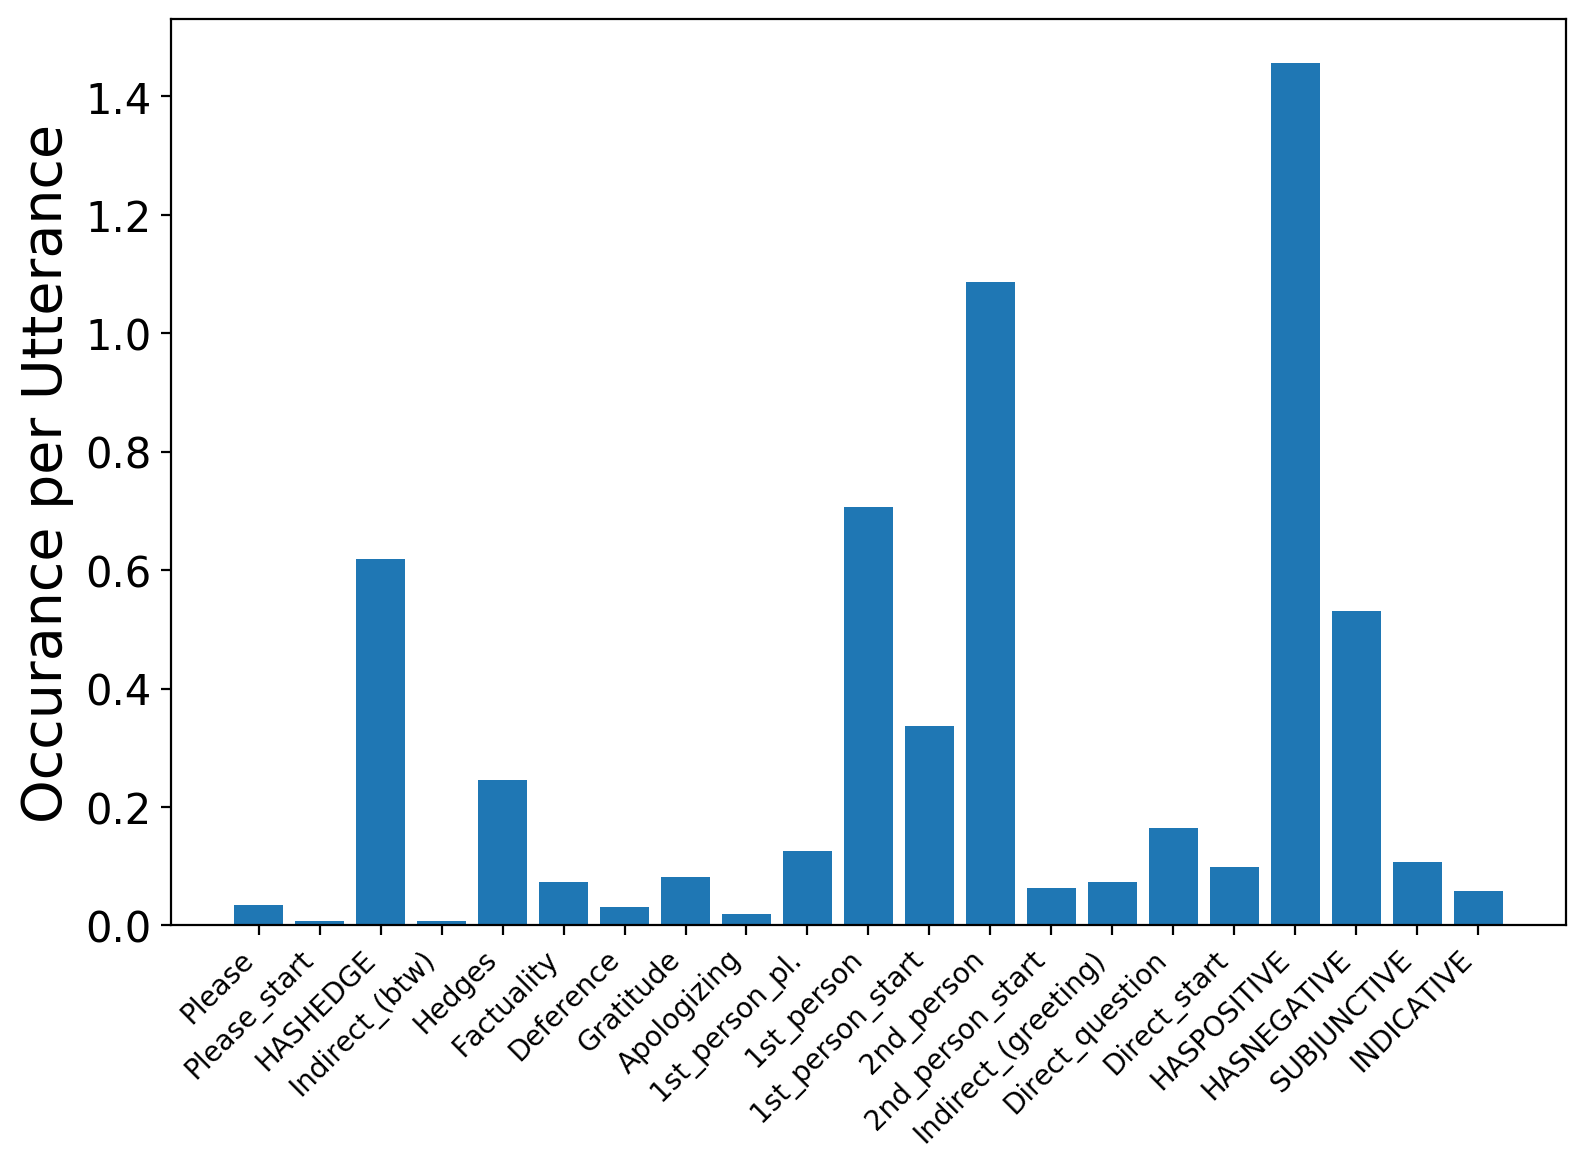

In [14]:
query = lambda x : x["politeness_strategies"]["feature_politeness_==HASPOSITIVE=="] == 1
positive_data = ps.summarize(wiki_corpus, query, plot = True)

#### 3. Predict Politeness 

We will see how a simple classifier considering the use of politeness strategies perform, using `Classifier` (note that this is only for demonstration, and not geared towards achieving best performance).

In [ ]:
import random
from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report

In [ ]:
from convokit import Classifier

As a prestep, we subset the corpus as we will only consider the polite vs. impolite class for prediction (i.e., those with "Binary" field being either +1 or -1). 

In [ ]:
binary_corpus = Corpus(utterances=[utt for utt in wiki_corpus.iter_utterances() if utt.meta["Binary"] != 0])

#### 3.1 Direct evaluation

If you are interested in how effectiveness are these politeness strategies, `Classifier` provides evaluation with both train/test splits, as well as with cross validaton. 

- cross validation accuracies

In [ ]:
clf_cv = Classifier(obj_type="utterance", 
                        pred_feats=["politeness_strategies"], 
                        labeller=lambda utt: utt.meta['Binary'] == 1)

clf_cv.evaluate_with_cv(binary_corpus)

- train/test split

In [ ]:
clf_split = Classifier(obj_type="utterance", 
                        pred_feats=["politeness_strategies"], 
                        labeller=lambda utt: utt.meta['Binary'] == 1)

clf_split.evaluate_with_train_test_split(binary_corpus)

#### 3.2 Training a classifier to predict on other utterances

In [ ]:
test_ids = binary_corpus.get_utterance_ids()[-100:]
train_corpus = Corpus(utterances=[utt for utt in binary_corpus.iter_utterances() if utt.id not in test_ids])
test_corpus = Corpus(utterances=[utt for utt in binary_corpus.iter_utterances() if utt.id in test_ids])
print("train size = {}, test size = {}".format(len(train_corpus.get_utterance_ids()),
                                               len(test_corpus.get_utterance_ids())))

We can also train a classifier with a corpus to predict politeness labels for other Utterances. As an example, we will first train with a training corpus, and check predictions on some test utterances. 

In [ ]:
clf = Classifier(obj_type="utterance", 
                        pred_feats=["politeness_strategies"], 
                        labeller=lambda utt: utt.meta['Binary'] == 1)
clf.fit(train_corpus)

- predicing on the test corpus (you can also predict on a list of utterances by using `clf.transform_objs()` instead) 

In [ ]:
test_pred = clf.transform(test_corpus)

In [ ]:
clf.summarize(test_pred)

To look at a few example predictions:

In [ ]:
pred2label = {1: "polite", 0: "impolite"}

for i, idx in enumerate(test_ids[0:5]):
    print(i)
    test_utt = test_corpus.get_utterance(idx)
    ypred, yprob = test_utt.meta['prediction'], test_utt.meta['score']
    print("test utterance:\n{}".format(test_utt.text))
    print("------------------------")
    print("Result: {}, probability estimates = {}\n".format(pred2label[ypred], yprob))

We can also check out the confusion matrix and classification report 

In [ ]:
clf.confusion_matrix(test_corpus)

In [ ]:
print(clf.classification_report(test_corpus))

We note that this is an implementation of a politeness classifier trained on a specific dataset (wikipedia) and on a specific binarization of politeness classes. Depending on your scenario, you might find it preferable to directly use the politeness strategies, as exemplified in the [conversations gone awry example](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/conversations-gone-awry/Conversations_Gone_Awry_Prediction.ipynb), rather than a politeness label/score.